# Survival analysis using Kaplan Meier model for ecoli cohort

## Read journeys data

In [1]:
import os

from pathlib import Path

import pandas as pd


journeysDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'data', 'full_cohort', 'journry_times.csv'))
journeysDf

,person_id,JOURNEY_ID,admittime_adm,deathtime_adm
0,2133327,567916,26/11/2018,NaN
1,2197822,572108,16/04/2019,17/07/2019
2,2138701,565491,12/11/2018,14/12/2021
3,330958,584875,02/03/2019,NaN
4,2189657,10719842,11/01/2019,NaN
...,...,...,...,...
6110,1855200,17748547,25/05/2023,NaN
6111,2240165,17881084,12/07/2023,29/07/2023
6112,2240165,17882738,12/07/2023,29/07/2023
6113,2514680,17883870,03/07/2023,NaN


## Read patient to tube mapping

In [2]:
import os

from pathlib import Path

import pandas as pd


mappingDf = pd.read_csv(Path(os.environ['GENOMICS_DATA_BASE'], 'patient_tube_id_mapping_full.tsv'), sep='\t')[['tube_code', 'PATIENT_ID']].drop_duplicates()
mappingDf

,tube_code,PATIENT_ID
0,AH19J072,213972.0
1,AH19J074,213972.0
2,AH19B003,526238.0
3,AH20A024,788941.0
4,AH20L041,1023735.0
...,...,...
3112,ALF22L076,639020.0
3113,ALF22L089,655404.0
3114,ALF22L138,2572048.0
3115,ALF23A102,2054964.0


## Merge mapping data with jouneys information

In [3]:
mergedDf = journeysDf.merge(
    mappingDf,
    how='inner',
    left_on='person_id',
    right_on='PATIENT_ID'
).drop(columns=['PATIENT_ID'])
mergedDf

,person_id,JOURNEY_ID,admittime_adm,deathtime_adm,tube_code
0,2133327,567916,26/11/2018,NaN,AH18K073
1,2133327,567916,26/11/2018,NaN,AH20C038
2,2197822,572108,16/04/2019,17/07/2019,AH19D031
3,2138701,565491,12/11/2018,14/12/2021,AH18K041
4,330958,584875,02/03/2019,NaN,AH19C004
...,...,...,...,...,...
5984,1855200,17748547,25/05/2023,NaN,ALF22D020
5985,2240165,17881084,12/07/2023,29/07/2023,AH19G055
5986,2240165,17882738,12/07/2023,29/07/2023,AH19G055
5987,2514680,17883870,03/07/2023,NaN,AH21G030


## Read lowscore tubeids

In [4]:
import os

from pathlib import Path

import pandas as pd


lowscoreTubeidsDf = pd.read_csv(Path(os.environ['GENOMICS_DATA_BASE'], 'survival_analysis', 'SAUR', 'lowscore_tubeids.txt'))
lowscoreTubeidsDf

,tube_id
0,AH18J001
1,AH18J002
2,AH18J014
3,AH18J030
4,AH18J037
...,...
385,ALF23C124
386,ALF23C128
387,ALF23C174
388,ALF23C182


## Read highscore tubeids

In [5]:
import os

from pathlib import Path

import pandas as pd


highscoreTubeidsDf = pd.read_csv(Path(os.environ['GENOMICS_DATA_BASE'], 'survival_analysis', 'SAUR', 'highscore_tubeids.txt'))
highscoreTubeidsDf

,tube_id
0,AH18J036
1,AH18J051
2,AH18J065
3,AH18K010
4,AH18K024
...,...
130,ALF23B065
131,ALF23B100
132,ALF23C044
133,ALF23C094


## low score journeys

### Create data

In [6]:
lowscoreDf = mergedDf.merge(
    lowscoreTubeidsDf,
    how='inner',
    left_on=['tube_code'],
    right_on=['tube_id']
)
lowscoreDf

,person_id,JOURNEY_ID,admittime_adm,deathtime_adm,tube_code,tube_id
0,2133327,567916,26/11/2018,NaN,AH18K073,AH18K073
1,2145022,601149,22/10/2018,04/06/2019,AH18J063,AH18J063
2,2085279,604416,15/11/2018,NaN,AH18K047,AH18K047
3,635723,2987983,13/11/2018,NaN,AH18K044,AH18K044
4,2091697,617886,19/12/2018,NaN,AH19F045,AH19F045
...,...,...,...,...,...,...
751,2676371,17444357,05/03/2023,NaN,ALF23C055,ALF23C055
752,2679272,17485225,09/03/2023,NaN,ALF23C124,ALF23C124
753,2131387,17513763,24/03/2023,NaN,ALF23C182,ALF23C182
754,1534999,17623924,20/04/2023,NaN,AH21H015,AH21H015


### Format data

In [7]:
from lifelines.utils import datetimes_to_durations

# start_times is a vector or list of datetime objects or datetime strings
# end_times is a vector or list of (possibly missing) datetime objects or datetime strings
T, E = datetimes_to_durations(lowscoreDf.admittime_adm, lowscoreDf.deathtime_adm, freq='D')

/home/vmadmin/workspace/alfred-data-analysis/.venv/lib/python3.10/site-packages/lifelines/utils/__init__.py:684: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  start_times_ = pd.to_datetime(start_times, dayfirst=dayfirst, format=format)
/home/vmadmin/workspace/alfred-data-analysis/.venv/lib/python3.10/site-packages/lifelines/utils/__init__.py:693: UserWarning: Warning: some values of start_times are after end_times.

  warnings.warn("Warning: some values of start_times are after end_times.\n", UserWarning)


### Kaplan Meier Plot

In [8]:
from lifelines import KaplanMeierFitter


kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)  # or, more succinctly, kmf.fit(T, E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 756 total observations, 489 right-censored observations>

<Axes: xlabel='timeline'>

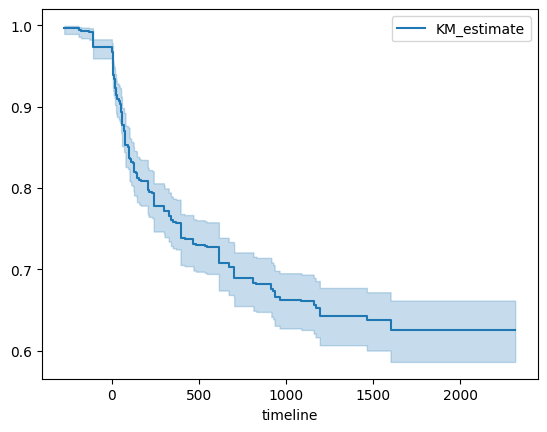

In [9]:
kmf.plot_survival_function()

## High score journeys

### Create data

In [10]:
highscoreDf = mergedDf.merge(
    highscoreTubeidsDf,
    how='inner',
    left_on=['tube_code'],
    right_on=['tube_id']
)
highscoreDf

,person_id,JOURNEY_ID,admittime_adm,deathtime_adm,tube_code,tube_id
0,2141593,594397,09/11/2018,11/11/2018,AH18K024,AH18K024
1,2126826,9702962,18/06/2019,NaN,AH19F053,AH19F053
2,2131221,9786008,04/11/2018,13/12/2018,AH18K010,AH18K010
3,2154700,10220218,21/10/2018,NaN,AH18J051,AH18J051
4,2126826,9702960,18/06/2019,NaN,AH19F053,AH19F053
...,...,...,...,...,...,...
204,2610027,17331736,23/01/2023,NaN,ALF23A127,ALF23A127
205,2642979,17356882,13/02/2023,28/03/2023,ALF23B100,ALF23B100
206,2489319,17480548,12/03/2023,NaN,ALF23C094,ALF23C094
207,2489319,17495399,12/03/2023,NaN,ALF23C094,ALF23C094


### Format data

In [16]:
from lifelines.utils import datetimes_to_durations

# start_times is a vector or list of datetime objects or datetime strings
# end_times is a vector or list of (possibly missing) datetime objects or datetime strings
T, E = datetimes_to_durations(highscoreDf.admittime_adm, highscoreDf.deathtime_adm, freq='D', dayfirst=True)

### Kaplan Meier Plot

In [17]:
from lifelines import KaplanMeierFitter


kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)  # or, more succinctly, kmf.fit(T, E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 209 total observations, 137 right-censored observations>

<Axes: xlabel='timeline'>

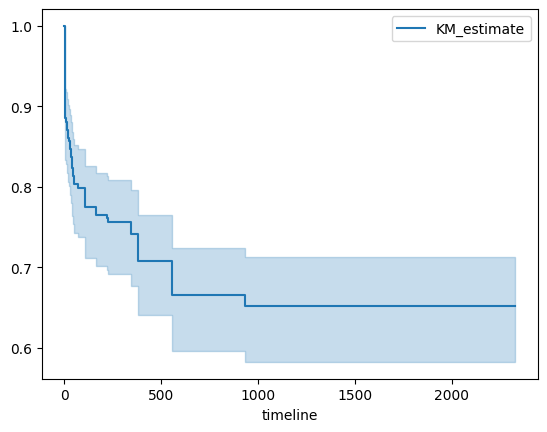

In [18]:
kmf.plot_survival_function()

## Overlapping survival analysis for low score and high score patients

### Create data

In [19]:
lowscoreDf = mergedDf.merge(
    lowscoreTubeidsDf,
    how='inner',
    left_on=['tube_code'],
    right_on=['tube_id']
)
lowscoreDf['cohort'] = 'Without Signature'
lowscoreDf

,person_id,JOURNEY_ID,admittime_adm,deathtime_adm,tube_code,tube_id,cohort
0,2133327,567916,26/11/2018,NaN,AH18K073,AH18K073,Without Signature
1,2145022,601149,22/10/2018,04/06/2019,AH18J063,AH18J063,Without Signature
2,2085279,604416,15/11/2018,NaN,AH18K047,AH18K047,Without Signature
3,635723,2987983,13/11/2018,NaN,AH18K044,AH18K044,Without Signature
4,2091697,617886,19/12/2018,NaN,AH19F045,AH19F045,Without Signature
...,...,...,...,...,...,...,...
751,2676371,17444357,05/03/2023,NaN,ALF23C055,ALF23C055,Without Signature
752,2679272,17485225,09/03/2023,NaN,ALF23C124,ALF23C124,Without Signature
753,2131387,17513763,24/03/2023,NaN,ALF23C182,ALF23C182,Without Signature
754,1534999,17623924,20/04/2023,NaN,AH21H015,AH21H015,Without Signature


In [20]:
highscoreDf = mergedDf.merge(
    highscoreTubeidsDf,
    how='inner',
    left_on=['tube_code'],
    right_on=['tube_id']
)
highscoreDf['cohort'] = 'With Signature'
highscoreDf

,person_id,JOURNEY_ID,admittime_adm,deathtime_adm,tube_code,tube_id,cohort
0,2141593,594397,09/11/2018,11/11/2018,AH18K024,AH18K024,With Signature
1,2126826,9702962,18/06/2019,NaN,AH19F053,AH19F053,With Signature
2,2131221,9786008,04/11/2018,13/12/2018,AH18K010,AH18K010,With Signature
3,2154700,10220218,21/10/2018,NaN,AH18J051,AH18J051,With Signature
4,2126826,9702960,18/06/2019,NaN,AH19F053,AH19F053,With Signature
...,...,...,...,...,...,...,...
204,2610027,17331736,23/01/2023,NaN,ALF23A127,ALF23A127,With Signature
205,2642979,17356882,13/02/2023,28/03/2023,ALF23B100,ALF23B100,With Signature
206,2489319,17480548,12/03/2023,NaN,ALF23C094,ALF23C094,With Signature
207,2489319,17495399,12/03/2023,NaN,ALF23C094,ALF23C094,With Signature


In [21]:
import pandas as pd


conbinedDf = pd.concat([highscoreDf, lowscoreDf], ignore_index=True)
conbinedDf

,person_id,JOURNEY_ID,admittime_adm,deathtime_adm,tube_code,tube_id,cohort
0,2141593,594397,09/11/2018,11/11/2018,AH18K024,AH18K024,With Signature
1,2126826,9702962,18/06/2019,NaN,AH19F053,AH19F053,With Signature
2,2131221,9786008,04/11/2018,13/12/2018,AH18K010,AH18K010,With Signature
3,2154700,10220218,21/10/2018,NaN,AH18J051,AH18J051,With Signature
4,2126826,9702960,18/06/2019,NaN,AH19F053,AH19F053,With Signature
...,...,...,...,...,...,...,...
960,2676371,17444357,05/03/2023,NaN,ALF23C055,ALF23C055,Without Signature
961,2679272,17485225,09/03/2023,NaN,ALF23C124,ALF23C124,Without Signature
962,2131387,17513763,24/03/2023,NaN,ALF23C182,ALF23C182,Without Signature
963,1534999,17623924,20/04/2023,NaN,AH21H015,AH21H015,Without Signature


### Format data

In [22]:
from lifelines.utils import datetimes_to_durations

# start_times is a vector or list of datetime objects or datetime strings
# end_times is a vector or list of (possibly missing) datetime objects or datetime strings
T, E = datetimes_to_durations(conbinedDf.admittime_adm, conbinedDf.deathtime_adm, freq='D', dayfirst=True)

conbinedDf['T'] = T
conbinedDf['E'] = E
conbinedDf

,person_id,JOURNEY_ID,admittime_adm,deathtime_adm,tube_code,tube_id,cohort,T,E
0,2141593,594397,09/11/2018,11/11/2018,AH18K024,AH18K024,With Signature,2.0,True
1,2126826,9702962,18/06/2019,NaN,AH19F053,AH19F053,With Signature,2087.0,False
2,2131221,9786008,04/11/2018,13/12/2018,AH18K010,AH18K010,With Signature,39.0,True
3,2154700,10220218,21/10/2018,NaN,AH18J051,AH18J051,With Signature,2327.0,False
4,2126826,9702960,18/06/2019,NaN,AH19F053,AH19F053,With Signature,2087.0,False
...,...,...,...,...,...,...,...,...,...
960,2676371,17444357,05/03/2023,NaN,ALF23C055,ALF23C055,Without Signature,731.0,False
961,2679272,17485225,09/03/2023,NaN,ALF23C124,ALF23C124,Without Signature,727.0,False
962,2131387,17513763,24/03/2023,NaN,ALF23C182,ALF23C182,Without Signature,712.0,False
963,1534999,17623924,20/04/2023,NaN,AH21H015,AH21H015,Without Signature,685.0,False


### Kaplan Meier Plot (complete timeline)

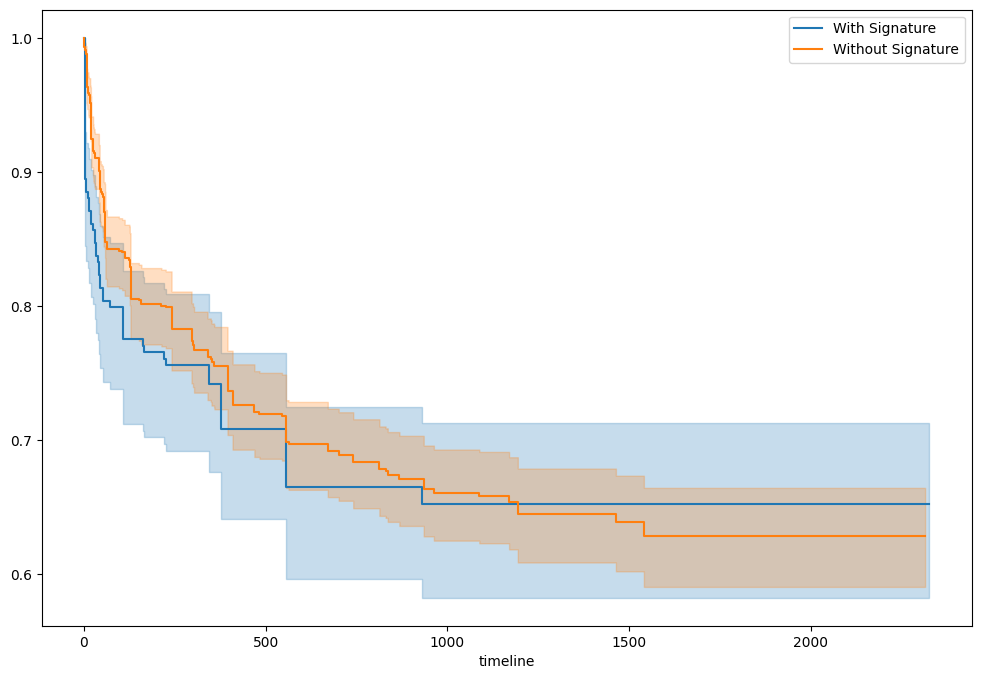

In [23]:
from matplotlib import pyplot as plt

f, ax = plt.subplots(1, 1, figsize=(12, 8))

kmf = KaplanMeierFitter()

for name, grouped_df in conbinedDf.groupby('cohort'):
    kmf.fit(grouped_df["T"], grouped_df["E"], label=name)
    kmf.plot_survival_function(ax=ax)

### Kaplan Meier Plot (zero to 1000 days)

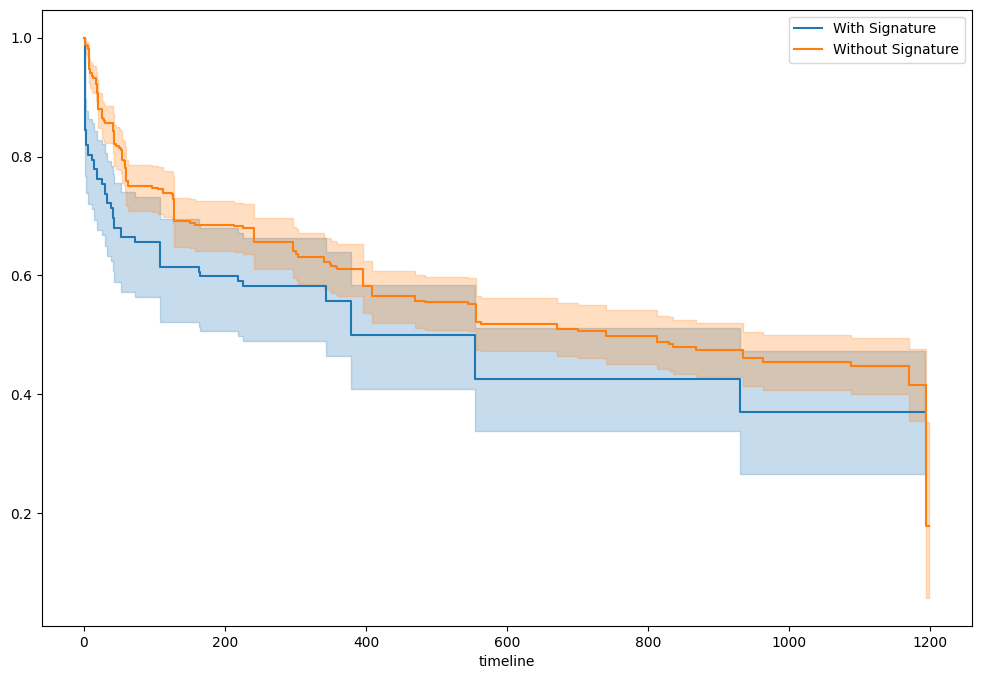

In [32]:
from matplotlib import pyplot as plt

f, ax = plt.subplots(1, 1, figsize=(12, 8))

kmf = KaplanMeierFitter()

for name, grouped_df in conbinedDf[(conbinedDf['T'] > 0) & (conbinedDf['T'] < 1200)].groupby('cohort'):
    kmf.fit(grouped_df["T"], grouped_df["E"], label=name)
    kmf.plot_survival_function(ax=ax)

## Log Rank Test

In [ ]:
# pip install Jinja2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 KB 4.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


### Complete timeline

In [25]:
from lifelines.statistics import logrank_test


results = logrank_test(
    conbinedDf[(conbinedDf.cohort == 'With Signature')]['T'],
    conbinedDf[(conbinedDf.cohort == 'Without Signature')]['T'],
    event_observed_A=conbinedDf[(conbinedDf.cohort == 'With Signature')]['E'],
    event_observed_B=conbinedDf[(conbinedDf.cohort == 'Without Signature')]['E'],
    )

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.08 0.77      0.37

### Zero to 1000 days

In [31]:
from lifelines.statistics import logrank_test

filteredDf = conbinedDf[(conbinedDf['T'] > 0) & (conbinedDf['T'] < 1200)]

results = logrank_test(
    filteredDf[(filteredDf.cohort == 'With Signature')]['T'],
    filteredDf[(filteredDf.cohort == 'Without Signature')]['T'],
    event_observed_A=filteredDf[(filteredDf.cohort == 'With Signature')]['E'],
    event_observed_B=filteredDf[(filteredDf.cohort == 'Without Signature')]['E'],
    )

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.50 0.03      4.88